## Load dataset with Time Series label

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('./dataset/cleaned_merged_dataset.csv')

In [4]:
data.Nature_Code.value_counts()

Military                2147
Passenger - Domestic    2005
Unknown                 1235
Cargo                    822
Passenger - Intl         695
Train/Test/Demo          340
Ferry/positioning        282
Executive                212
Private                  169
Agricultural              71
Illegal Flight            58
Ambulance                 38
Fire fighting             24
Name: Nature_Code, dtype: int64

In [5]:
mask = (data.Nature_Code != 'Military')
data = data[mask]
mask = (data.Year > 1960)
data = data[mask]

In [6]:
data.shape

(4626, 40)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4626 entries, 0 to 7562
Data columns (total 40 columns):
Engines               4626 non-null object
Narrative             4626 non-null object
FlightNumber          4626 non-null int64
AirplaneDamage        4626 non-null object
Phase                 4626 non-null object
DestinationAirport    4626 non-null object
Date                  4626 non-null int64
Time                  4626 non-null object
DepartureAirport      4626 non-null object
Operator              4626 non-null object
AirplaneFate          4626 non-null object
FirstFlight           4626 non-null int64
Nature_Code           4626 non-null object
Type_Code             4626 non-null object
Engine_Type           4626 non-null object
Engine_count          4626 non-null float64
Crew_Fatal            4626 non-null int64
Crew_Occ              4626 non-null int64
Total_Fatal           4626 non-null int64
Total_Occ             4626 non-null int64
Psngr_Fatal           4626 non-null int

## Separate out the features required for Time Series analysis

In [8]:
data = data[['Year', 'Month','Date', 'Day', 'Time', 'Seasons', 'Continents', 'Total_Fatal']]

## Voila!

In [9]:
data.head()

,Year,Month,Date,Day,Time,Seasons,Continents,Total_Fatal
0,2017,FEB,9,Thursday,16:11,Winter,North America,0
1,2017,MAY,5,Friday,06:53,Spring,North America,2
2,2017,MAY,1,Monday,14:00,Spring,North America,1
206,2017,APR,19,Wednesday,22:00,Spring,Asia,0
207,2017,APR,13,Thursday,16:33,Spring,Asia,0


In [10]:
data.reset_index(drop = True, inplace = True)

In [11]:
data.head()

,Year,Month,Date,Day,Time,Seasons,Continents,Total_Fatal
0,2017,FEB,9,Thursday,16:11,Winter,North America,0
1,2017,MAY,5,Friday,06:53,Spring,North America,2
2,2017,MAY,1,Monday,14:00,Spring,North America,1
3,2017,APR,19,Wednesday,22:00,Spring,Asia,0
4,2017,APR,13,Thursday,16:33,Spring,Asia,0


In [12]:
data.dtypes

Year            int64
Month          object
Date            int64
Day            object
Time           object
Seasons        object
Continents     object
Total_Fatal     int64
dtype: object

## Convert  Month and Time to integers

**What does strptime do?**
- Strptime create a datetime object provided a string and its format is provided.
- For eg: Here, I want Month in string to be converted to integer. The format for month is %b
- For converting time represented as HH:MM:SS it is %X
- ll formats have been specified in details in https://docs.python.org/2/library/datetime.html#datetime-objects 

In [13]:
datetime.strptime('Jan', '%b')

datetime.datetime(1900, 1, 1, 0, 0)

In [14]:
datetime.strptime(':'.join(['12:00', '00']), '%X').timetuple().tm_min

0

** strptime Month and Time which is currently in string format **

In [15]:
data.dtypes

Year            int64
Month          object
Date            int64
Day            object
Time           object
Seasons        object
Continents     object
Total_Fatal     int64
dtype: object

In [16]:
data['Month'].value_counts()

JAN    949
MAR    909
FEB    790
APR    749
MAY    674
JUN    459
JUL     90
AUG      6
Name: Month, dtype: int64

In [17]:
data['Month'] = [datetime.strptime(m, '%b').month 
                 for m in data['Month']]

In [18]:
data['Month'].value_counts()

1    949
3    909
2    790
4    749
5    674
6    459
7     90
8      6
Name: Month, dtype: int64

In [19]:
data.ix[data['Time'] == '24:00', 'Time'] = '23:59'

In [20]:
time = []
for t in data['Time']:
    if 'ca.' in t:
        t = t[4:9]
    elif 'c' in t:
        t = t[2:7]
    elif len(t) != 5:
        t = t[0:5]
    else:
        pass
    time.append(t)
data['Time'] = time

In [21]:
data['Hour'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_hour
                 for t in data['Time']]

In [22]:
data['Min'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_min
                 for t in data['Time']]

In [23]:
data.dtypes

Year            int64
Month           int64
Date            int64
Day            object
Time           object
Seasons        object
Continents     object
Total_Fatal     int64
Hour            int64
Min             int64
dtype: object

In [24]:
data.loc[(data['Date'] == 0) & (data['Month'] == 2), 'Date'] = 28

In [25]:
data.loc[(data['Date'] == 0) & 
         ((data['Month'] == 4) | (data['Month'] == 6) | (data['Month'] == 9) | (data['Month'] == 11)), 'Date'] = 30

In [26]:
data.loc[(data['Date'] == 0), 'Date'] = 31

In [27]:
data['Date'].value_counts()

2     186
6     178
15    169
17    168
18    164
10    164
14    164
5     162
11    162
8     161
4     160
3     160
1     159
9     158
28    158
24    152
7     151
20    149
19    146
16    146
13    146
12    145
22    138
25    137
27    136
23    132
26    128
21    125
29    109
30    108
31    105
Name: Date, dtype: int64

## What are you waiting for ... Join Year, month, Date and Time!!
**Create time series**

In [28]:
data['DateTime'] = data[['Year', 'Month', 'Date', 'Hour', 'Min']].apply(lambda s : datetime(*s),axis = 1)

In [29]:
data.head()

,Year,Month,Date,Day,Time,Seasons,Continents,Total_Fatal,Hour,Min,DateTime
0,2017,2,9,Thursday,16:11,Winter,North America,0,16,11,2017-02-09 16:11:00
1,2017,5,5,Friday,06:53,Spring,North America,2,6,53,2017-05-05 06:53:00
2,2017,5,1,Monday,14:00,Spring,North America,1,14,0,2017-05-01 14:00:00
3,2017,4,19,Wednesday,22:00,Spring,Asia,0,22,0,2017-04-19 22:00:00
4,2017,4,13,Thursday,16:33,Spring,Asia,0,16,33,2017-04-13 16:33:00


In [30]:
# Drop redundant datetime columns
data = data[['DateTime', 'Seasons', 'Continents', 'Total_Fatal']]

In [31]:
data.head()

,DateTime,Seasons,Continents,Total_Fatal
0,2017-02-09 16:11:00,Winter,North America,0
1,2017-05-05 06:53:00,Spring,North America,2
2,2017-05-01 14:00:00,Spring,North America,1
3,2017-04-19 22:00:00,Spring,Asia,0
4,2017-04-13 16:33:00,Spring,Asia,0


In [32]:
data.index = data['DateTime']

In [33]:
data = data[['Seasons', 'Continents', 'Total_Fatal']]
time_data = data[:]
data.head()

,Seasons,Continents,Total_Fatal
DateTime,,,
2017-02-09 16:11:00,Winter,North America,0
2017-05-05 06:53:00,Spring,North America,2
2017-05-01 14:00:00,Spring,North America,1
2017-04-19 22:00:00,Spring,Asia,0
2017-04-13 16:33:00,Spring,Asia,0


In [34]:
data_s = data[['Seasons']]
data_c = data[['Continents']]
data_f = data[['Total_Fatal']]

In [35]:
data_f.head()

,Total_Fatal
DateTime,
2017-02-09 16:11:00,0
2017-05-05 06:53:00,2
2017-05-01 14:00:00,1
2017-04-19 22:00:00,0
2017-04-13 16:33:00,0


**Plotting Number of Fatalities over time period**

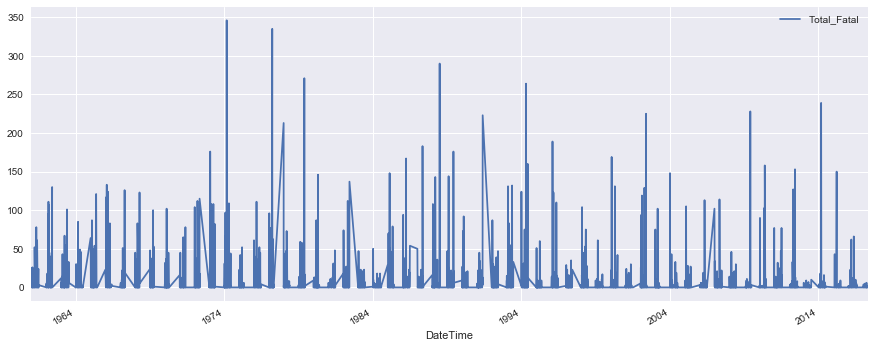

In [36]:
data_f.plot(figsize=(15, 6))
plt.show()

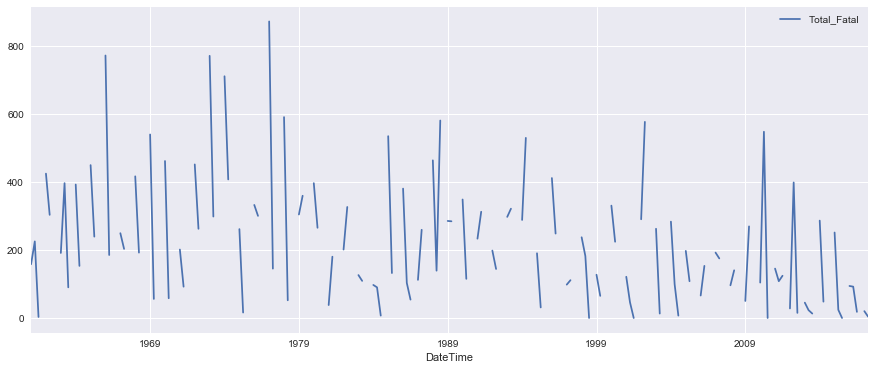

In [37]:
data_f.resample('Q', how = 'sum').plot()

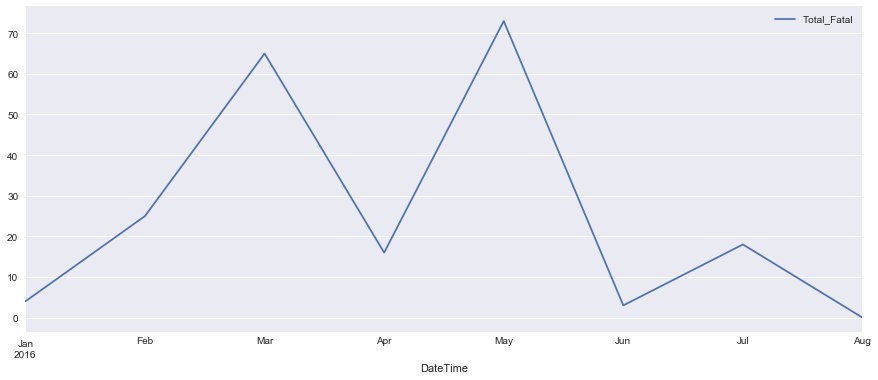

In [38]:
data_f['2016'].resample('M', how = 'sum').plot()

## Seasonal variation

In [39]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

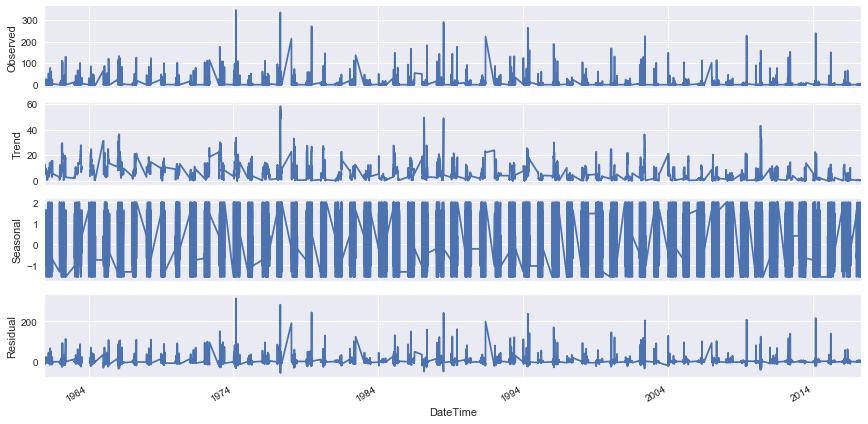

In [40]:
decomposition = seasonal_decompose(data_f.Total_Fatal, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

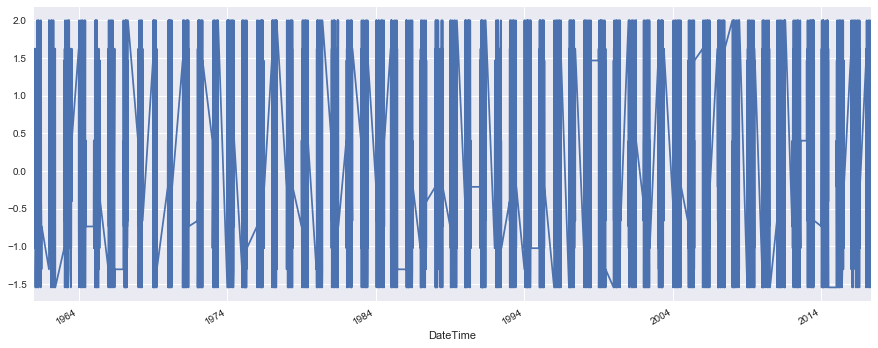

In [41]:
# grab just one graphic doing the following:
seasonal = decomposition.seasonal
seasonal.plot()

## Checking Stationarity
- If a time series is stationary, **the mean, variance, and autocorrelation are constant over time**. Forecasting methods typically assume that the timeseries you are forcasting on are stationary, or at least approximately stationary.
- The most common way to make a timeseries stationary is to perform *differencing*. 
- This removes trends in the timeseries and ensures that the **mean across time is zero**. In most cases there will only be a need for a single differencing, although sometimes a second difference (or even more) will be taken to remove trends.

**Dickey-Fuller test of stationarity**

In [42]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 


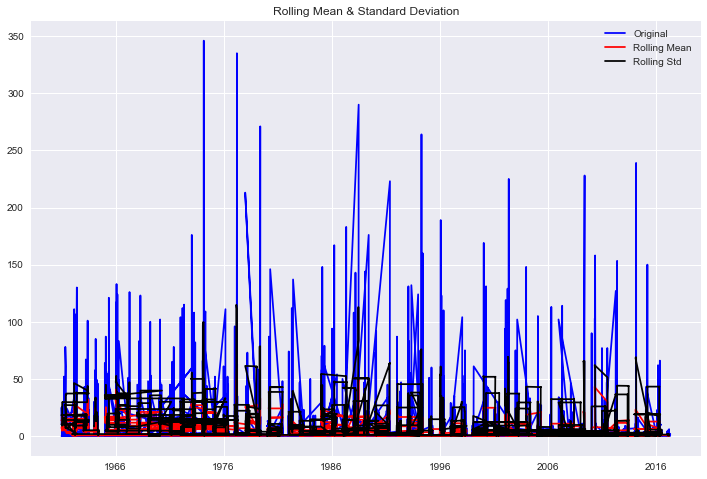

Results of Dickey-Fuller Test:
Test Statistic                  -61.212890
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    4625.000000
Critical Value (1%)              -3.431765
Critical Value (5%)              -2.862165
Critical Value (10%)             -2.567103
dtype: float64


In [43]:
# perform test
test_stationarity(data_f.Total_Fatal)

## Sarimax Model

In [44]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = data_f.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 4626
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood              -20912.732
Date:                           Sun, 28 May 2017   AIC                          41831.464
Time:                                   13:52:30   BIC                          41850.782
Sample:                                        0   HQIC                         41838.261
                                          - 4626                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9972      0.001   -753.441      0.000      -1.000      -0.995
ma.S.L4       -0.9989      0.003   -379.070

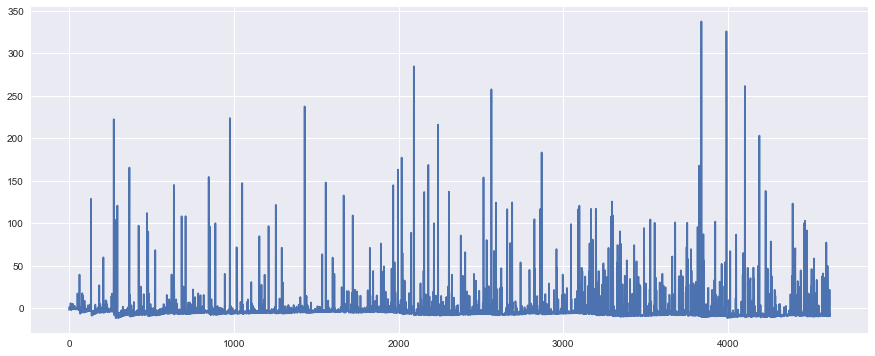

In [45]:
# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

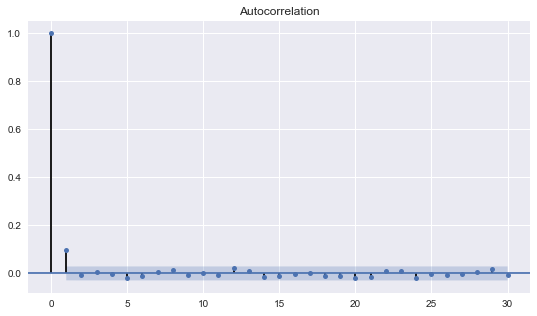

In [46]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

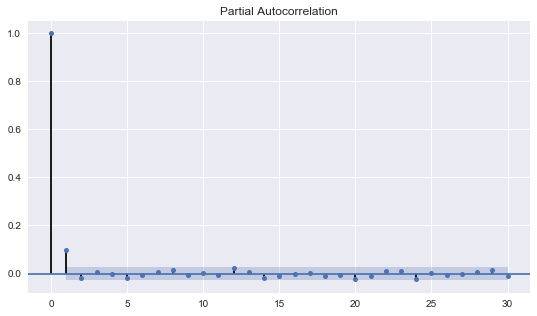

In [47]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

In [48]:
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,2), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 4626
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood              -20889.251
Date:                           Sun, 28 May 2017   AIC                          41786.502
Time:                                   13:52:36   BIC                          41812.260
Sample:                                        0   HQIC                         41795.566
                                          - 4626                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8994      0.041    -22.028      0.000      -0.979      -0.819
ma.L2         -0.1006      0.008    -13.185

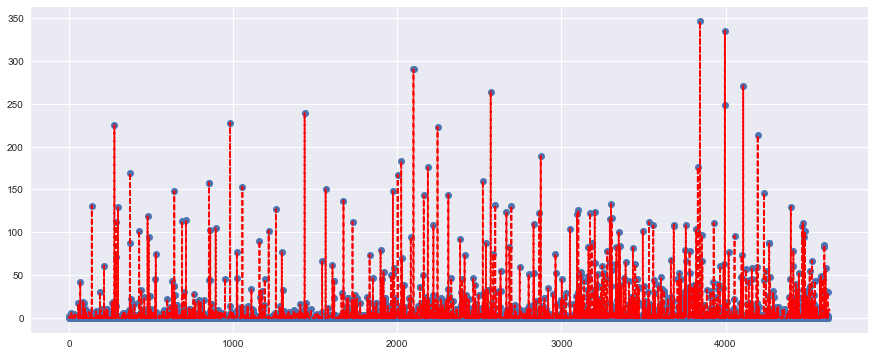

In [49]:
# forecasting
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

In [50]:
q = ['Q1', 'Q2', 'Q3', 'Q4']
data_s.loc[data_s['Seasons'] == 'Summer', 'Seasons'] = 'Q1'
data_s.loc[data_s['Seasons'] == 'Autumn', 'Seasons'] = 'Q2'
data_s.loc[data_s['Seasons'] == 'Winter', 'Seasons'] = 'Q3'
data_s.loc[data_s['Seasons'] == 'Spring', 'Seasons'] = 'Q4'
data_s.head()

,Seasons
DateTime,
2017-02-09 16:11:00,Q3
2017-05-05 06:53:00,Q4
2017-05-01 14:00:00,Q4
2017-04-19 22:00:00,Q4
2017-04-13 16:33:00,Q4


In [51]:
# Is y series Whitenoise?

In [52]:
# summary stats
print(data_f.describe())

       Total_Fatal
count  4626.000000
mean      6.118245
std      22.293319
min       0.000000
25%       0.000000
50%       0.000000
75%       2.000000
max     346.000000


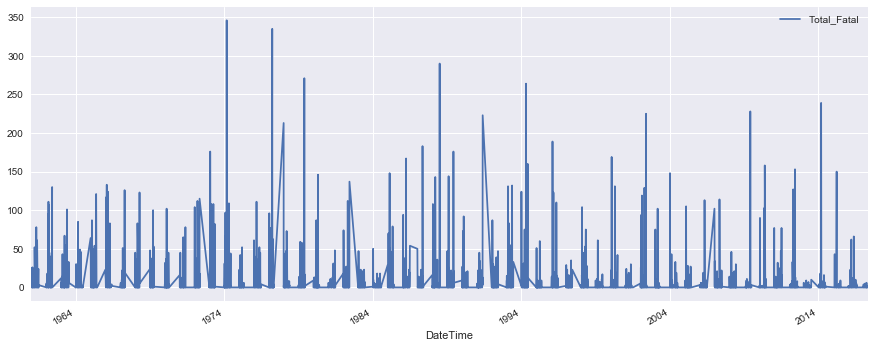

In [53]:
data_f.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d1e5400>]], dtype=object)

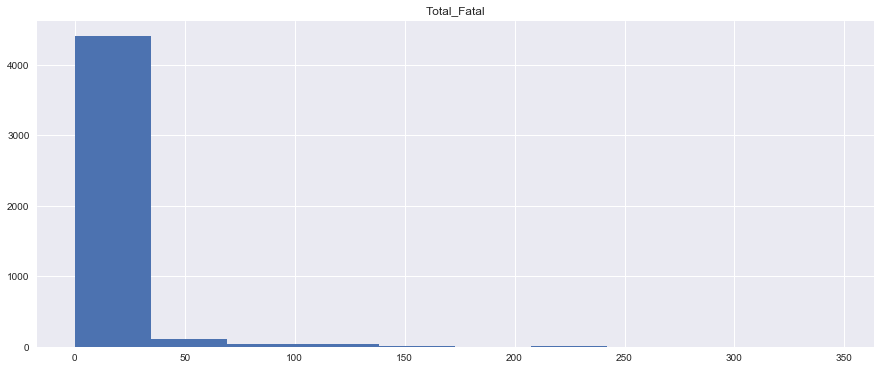

In [54]:
data_f.hist()

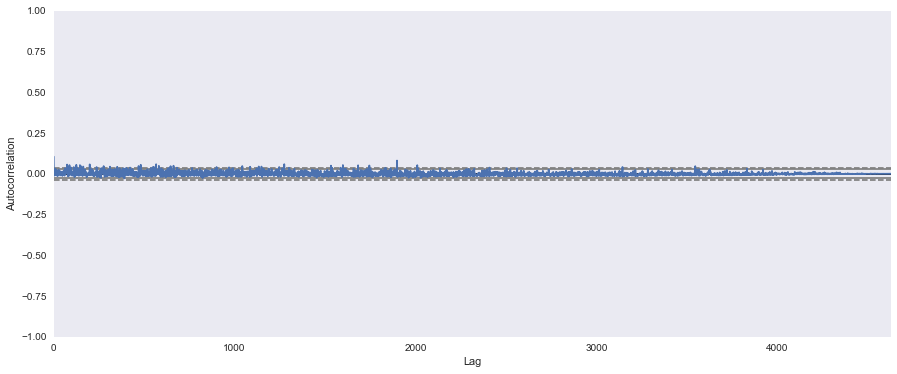

In [55]:
from pandas.tools.plotting import autocorrelation_plot
# autocorrelation
autocorrelation_plot(data_f)

## Start my Time Series Analysis
- The time series data below has the following information:
    - Each row or datapoint represents a single accident and the season, continent it has occured and no of fatalities involved in it.
- What can I analyze here?
    - Is there a seasonal trend observed in the overall no of crashes over the years?
    - Breaking down the above problem even further:
        - What is the seasonal trend observed in the no of accidents in different continents.
    - At this point, the no of fatalities does not look like a good factor to check for trends.
    
- What other factors from the main dataset can be considered here?
    - The Airline information
    - The aircraft information
    - Age of the airline information
    - Engine information
    - The country
    - The latlon
- What is the most accident prone latitude-longitude ranges?

### Is there a seasonal trend observed in the overall no of crashes over the years?
- The dataframe below needs to be modified to anakyze this statement.
- The dataset needs to be changed to a slightly different format:
- Groupby Continents such that:
    - time series index --> year-month
    - features --> count of accidents
- The total fatalities is not required here


In [56]:
data_t1 = time_data[:]
data_t1.head()

,Seasons,Continents,Total_Fatal
DateTime,,,
2017-02-09 16:11:00,Winter,North America,0
2017-05-05 06:53:00,Spring,North America,2
2017-05-01 14:00:00,Spring,North America,1
2017-04-19 22:00:00,Spring,Asia,0
2017-04-13 16:33:00,Spring,Asia,0


In [57]:
data_t1['AccidentCount'] = [1 for i in range(0, len(data_t1))]

In [58]:
data_t1.reset_index(inplace = True)
data_t1.dtypes

DateTime         datetime64[ns]
Seasons                  object
Continents               object
Total_Fatal               int64
AccidentCount             int64
dtype: object

In [59]:
data_t1['Date'] = data_t1['DateTime'].apply(lambda x: datetime.date(x))
data_t1.set_index('Date', inplace=True)
data_t1.index = pd.to_datetime(data_t1.index)

In [60]:
data_t1.head(2)

,DateTime,Seasons,Continents,Total_Fatal,AccidentCount
Date,,,,,
2017-02-09,2017-02-09 16:11:00,Winter,North America,0,1
2017-05-05,2017-05-05 06:53:00,Spring,North America,2,1


In [61]:
# data_t1 = data_t1.resample('M', how="count")
data_t1 = data_t1.resample('M',how={'Total_Fatal':'sum', 'AccidentCount':'sum', 'Continents':'last', 'Seasons':'last'})

In [62]:
data_t1 = data_t1.fillna(0)

In [63]:
# print(data_t1.shape)
print('Resample resulted in entries {} months over %d years'.format(data_t1.shape[0])%(data_t1.shape[0]/12))

Resample resulted in entries 677 months over 56 years


In [64]:
# Get only the Count and Index
data_count = data_t1[['AccidentCount']]

In [65]:
data_t1.tail()

,Total_Fatal,AccidentCount,Continents,Seasons
Date,,,,
2017-01-31,8.0,13.0,South America,Summer
2017-02-28,5.0,7.0,South America,Summer
2017-03-31,7.0,14.0,South America,Autumn
2017-04-30,1.0,8.0,Asia,Spring
2017-05-31,3.0,2.0,North America,Spring


## Are there any trends?

In [66]:
data_count.describe()

,AccidentCount
count,677.000000
mean,6.833087
std,7.938571
min,0.000000
25%,0.000000
50%,0.000000
75%,13.000000
max,30.000000


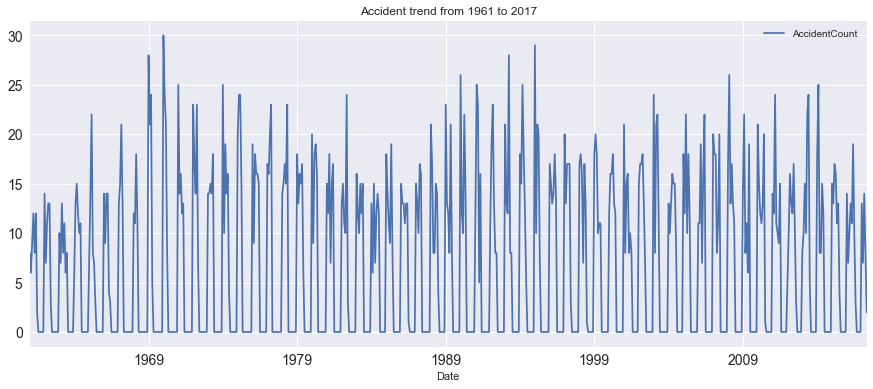

In [67]:
plt.figure(figsize=(8,8))
data_count.plot(title='Accident trend from 1961 to 2017', fontsize = 14)

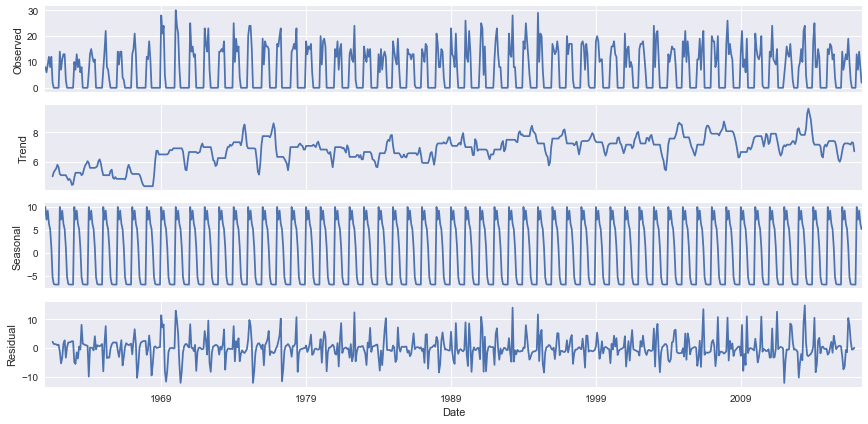

In [68]:
decomposition = seasonal_decompose(data_count.AccidentCount, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

## Any outliers?

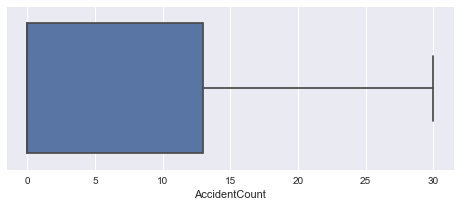

In [69]:
ax = plt.figure(figsize=(8,3))
sns.boxplot(data=data_count, x='AccidentCount')

## Check Auto Correlation

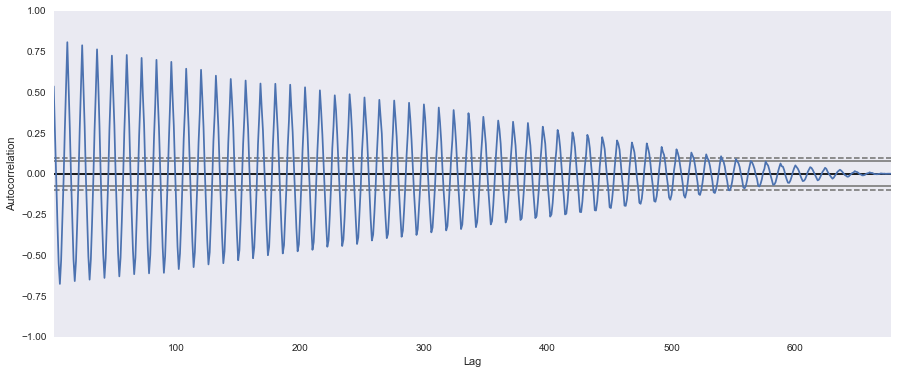

In [70]:
from pandas.tools.plotting import autocorrelation_plot
# autocorrelation
autocorrelation_plot(data_count)

## Check Stationarity

In [71]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 


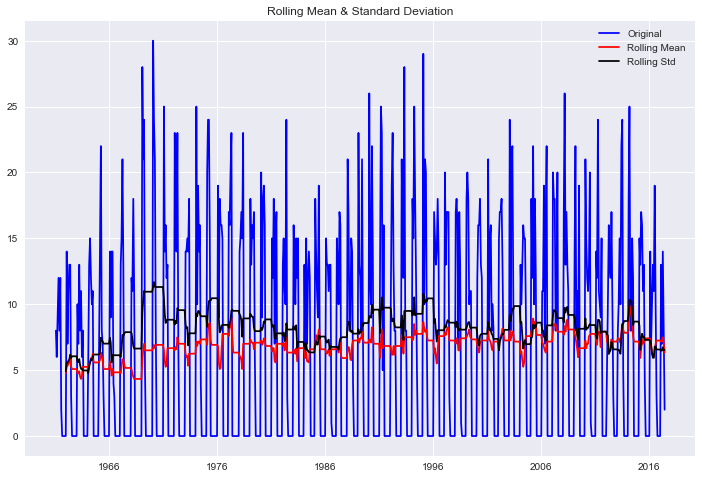

Results of Dickey-Fuller Test:
Test Statistic                  -3.883228
p-value                          0.002162
#Lags Used                      16.000000
Number of Observations Used    660.000000
Critical Value (1%)             -3.440297
Critical Value (5%)             -2.865929
Critical Value (10%)            -2.569107
dtype: float64


In [72]:
# perform test
test_stationarity(data_count.AccidentCount)

## Perform test on the first-differenced timeseries

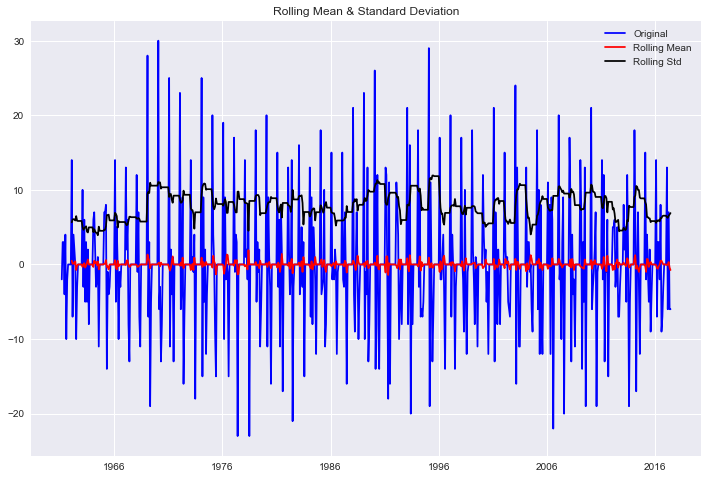

Results of Dickey-Fuller Test:
Test Statistic                -1.481252e+01
p-value                        2.020214e-27
#Lags Used                     1.500000e+01
Number of Observations Used    6.600000e+02
Critical Value (1%)           -3.440297e+00
Critical Value (5%)           -2.865929e+00
Critical Value (10%)          -2.569107e+00
dtype: float64


In [73]:
# first difference
data_count['first_difference'] = data_count.AccidentCount - data_count.AccidentCount.shift(1)  
test_stationarity(data_count.first_difference.dropna(inplace=False))

## Perform test on seasonal-differenced timeseries

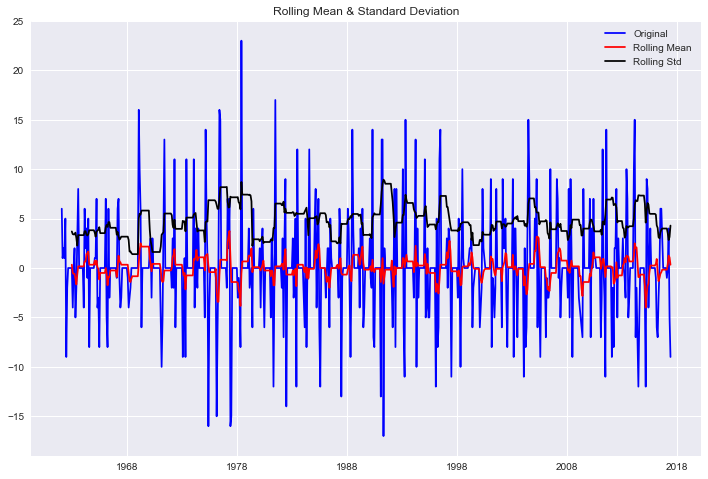

Results of Dickey-Fuller Test:
Test Statistic                -9.855320e+00
p-value                        4.375179e-17
#Lags Used                     1.600000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [74]:
# first difference
data_count['seasonal_difference'] = data_count.AccidentCount - data_count.AccidentCount.shift(12)  
test_stationarity(data_count.seasonal_difference.dropna(inplace=False))

## Seasonal ARIMA with additional predictors (SARIMAX)

In [77]:
import statsmodels.api as sm
df = data_count.stack().values
model = sm.tsa.statespace.SARIMAX(df, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

ValueError: non-invertible starting seasonal moving average parameters found with `enforce_invertibility` set to True.

In [ ]:
# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

In [ ]:
# Plot the ACF and PACF of the residuals.
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

In [ ]:
# Increase order of the sarimax model
model = sm.tsa.statespace.SARIMAX(df, order=(0,1,2), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

In [1]:
# forecasting
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((df, preds), axis=0)

plt.figure();
plt.plot(df, 'o' , fcast, 'r--')

NameError: name 'model' is not defined

## Checking from the ARIMA Example

In [911]:
import itertools

In [912]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [927]:
data_count.drop('first_difference', inplace = True, axis = 1)
data_count.head()

,AccidentCount
Date,
1961-01-31,8.0
1961-02-28,6.0
1961-03-31,9.0
1961-04-30,12.0
1961-05-31,8.0


In [928]:
y = pd.Series(index = data_count.index, data = data_count.AccidentCount)

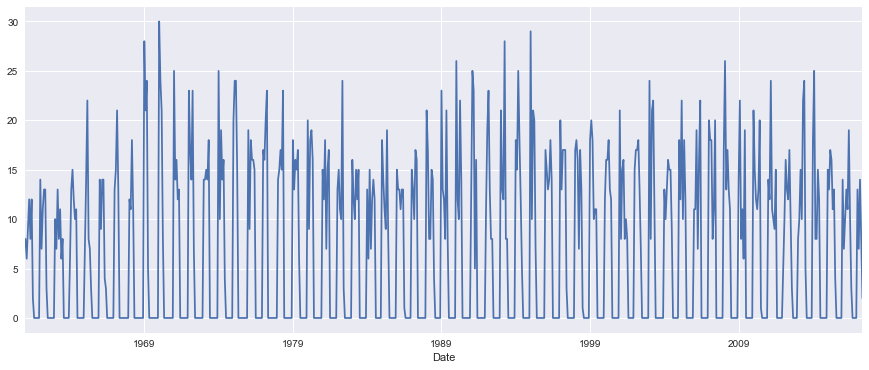

In [930]:
y.plot(figsize=(15, 6))
plt.show()

In [931]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4568.805455189746
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3663.2263606297693
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3959.5336342446963
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3730.932724965375
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3765.0379725482253
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3661.849756362966
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4782.582975926518
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4410.5690434001735
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3981.144048709168
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3657.8140831089518
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3961.513135202782
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3725.696978219423
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3766.1600319759978
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3657.3326769715327
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4436.074833047276
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4063.936288764076
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4319.230264316158
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:4139.098461339008
ARI

In [932]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0386      0.032      1.218      0.223      -0.024       0.101
ma.L1         -0.9974      0.015    -66.573      0.000      -1.027      -0.968
ar.S.L12       0.1137      0.034      3.349      0.001       0.047       0.180
ma.S.L12      -0.8543      0.024    -35.931      0.000      -0.901      -0.808
sigma2        15.6094      0.665     23.464      0.000      14.306      16.913


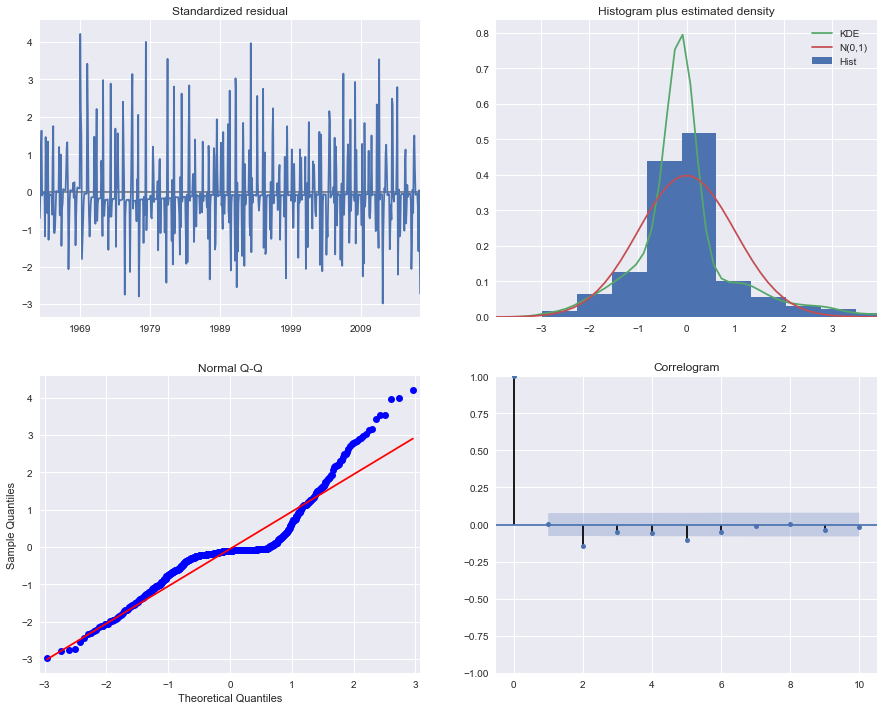

In [933]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [949]:
x = pd.to_datetime('2017-01-31')
pred = results.get_prediction(start=x, dynamic=True)
pred_ci = pred.conf_int()

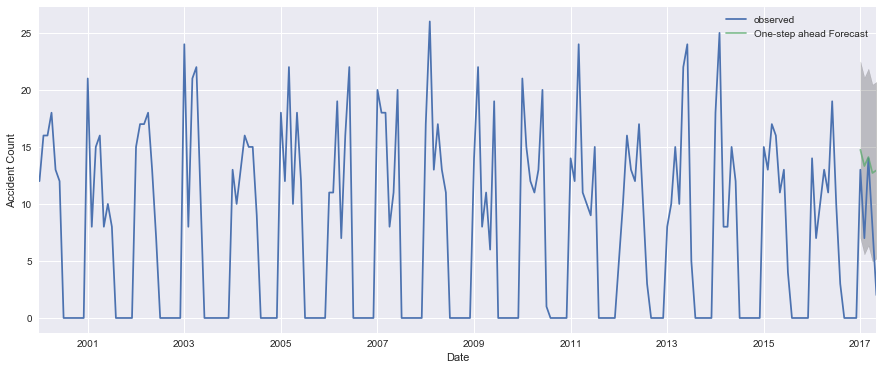

In [954]:
ax = y['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')
plt.legend()

plt.show()

In [956]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 37.05


In [957]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

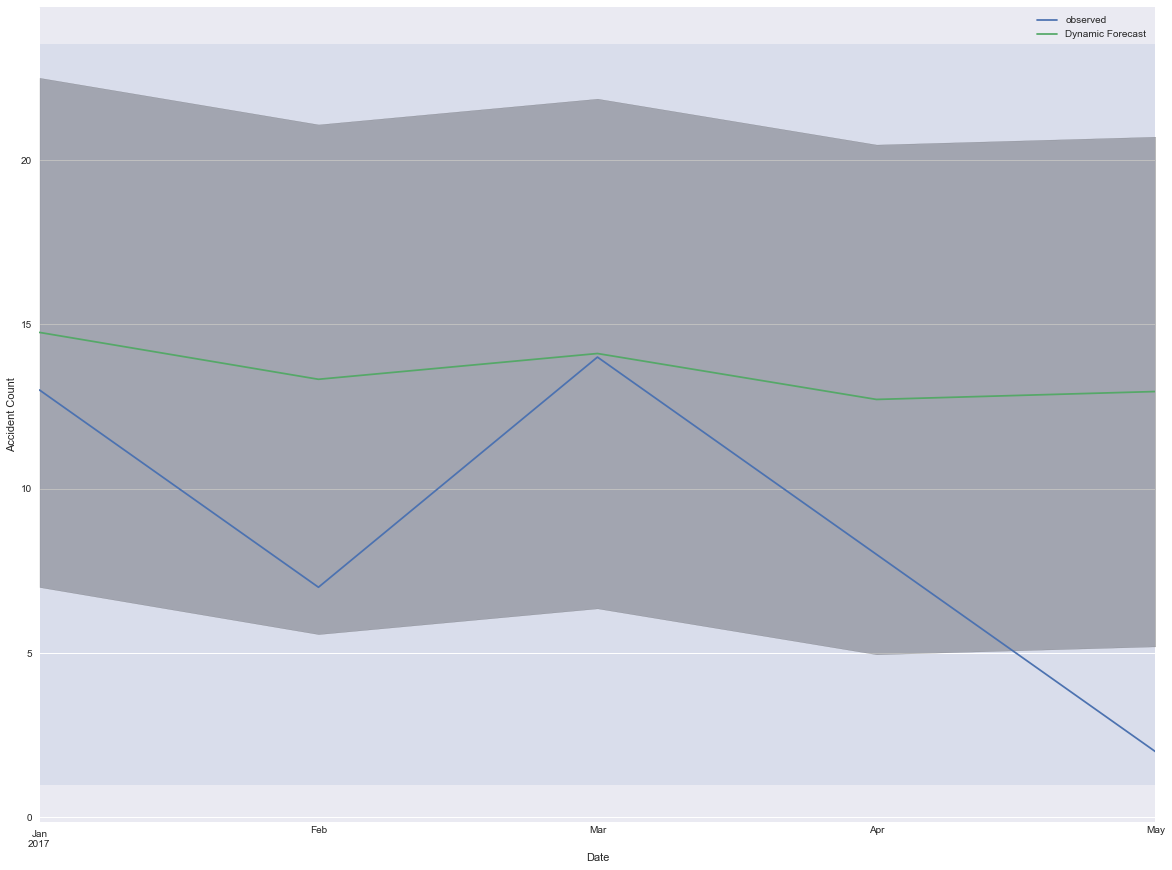

In [964]:
ax = y['2017':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')

plt.legend()
plt.show()

In [965]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2017-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 37.05


In [960]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

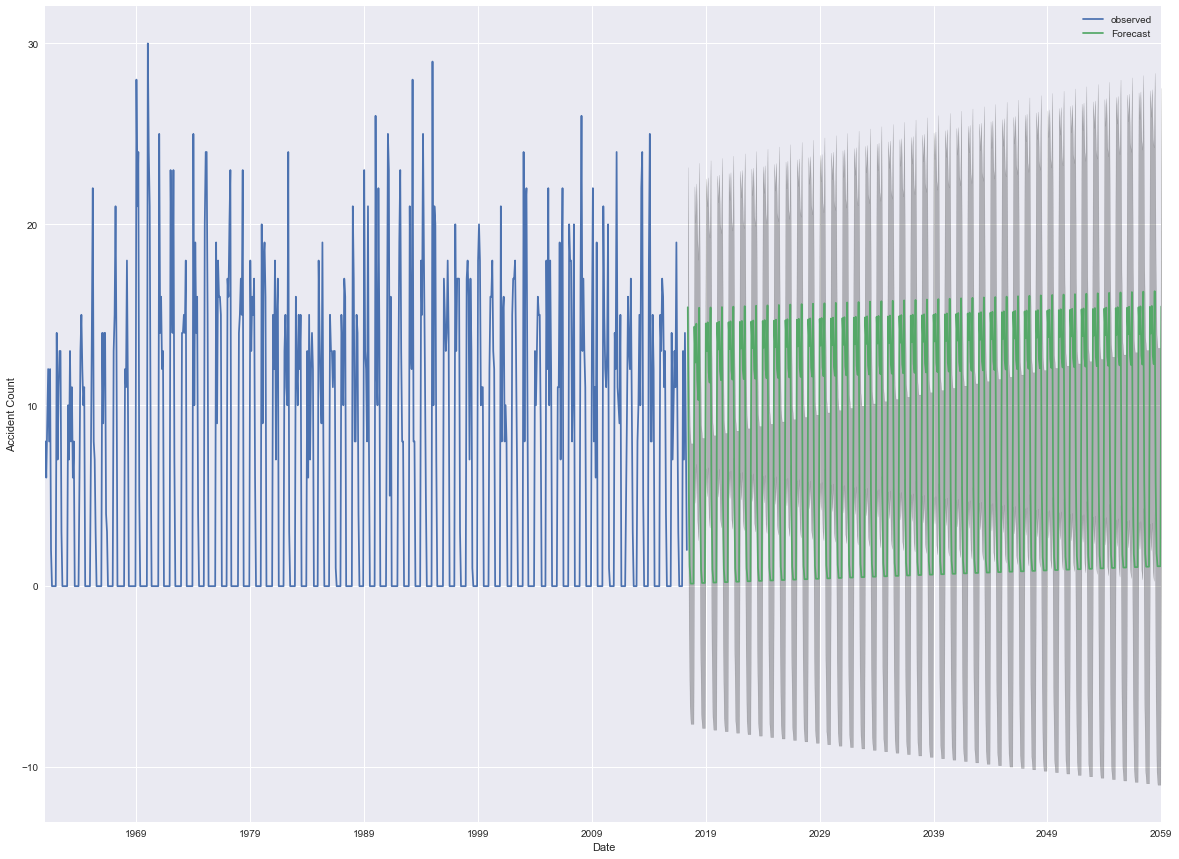

In [962]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')

plt.legend()
plt.show()